In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=10000)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

from tensorflow import keras
from tifffile import imsave, imread, imwrite
from keras.models import Input, Model
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau,LearningRateScheduler
from tifffile import imwrite

from datagenerator_2D import data_generator
from model_2D_interconnect import make_generator
# from Model_2D_Unet import make_generator
# from Model_2D_RCAN import make_generator

from loss_2D import generator_loss
# from skimage import exposure
# from skimage.exposure import match_histograms
# from skimage.exposure import histogram

1 Physical GPUs, 1 Logical GPUs


In [3]:
patch_size = 256
n_patches =  16
n_channel =  0
augment = False
shuffle = True 
batch_size = 1
add_noise= False
lp = 0.5

GT_image_dr = r'D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\STED 70\Average.tif'
lowSNR_image_dr =r'D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\STED 70\1frame.tif'

x_train, y_train, x_valid, y_valid = data_generator(GT_image_dr, lowSNR_image_dr, patch_size, n_patches,
                                                    n_channel, threshold = 0.4,ratio=1.0,lp=lp, augment=augment, shuffle=shuffle,
                                                   add_noise=add_noise)

(9, 1, 1024, 1024)
2101
The training set shape is: (2101, 256, 256, 1)
The validation set shape is: (0, 256, 256, 1)


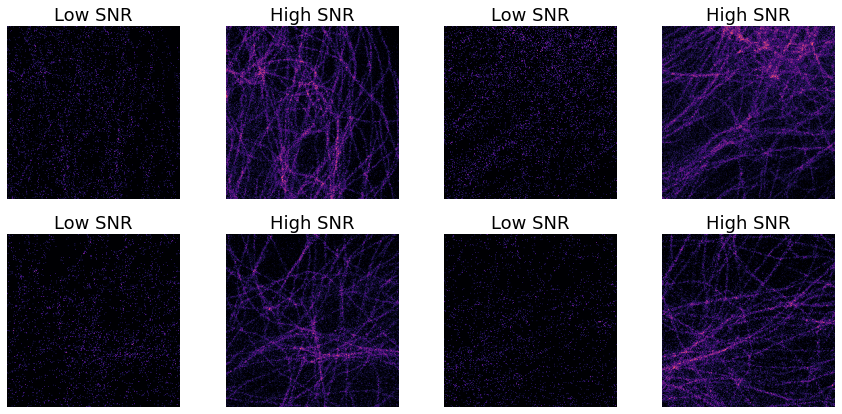

In [5]:
ix = random.sample(range(len(x_train)),4)
fig = plt.figure(figsize=(15,7))

for i in range(4):
    norm_x = np.linalg.norm(x_train[ix[i]], axis=(0, 1))
    fig.add_subplot(2,4, 2*i+1)
    cmap=plt.get_cmap('magma')
    plt.imshow(x_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('Low SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')
    
    fig.add_subplot(2,4, 2*i+2)
    cmap=plt.get_cmap('magma')
    plt.imshow(y_train[ix[i],:,:,0].squeeze(),cmap)
    plt.title('High SNR',fontdict={'fontsize':18})
    plt_axis = plt.axis('off')

In [6]:
model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5" 
load_model_save_directory = r"D:\Projects\Denoising-STED\20220913-RPI\tubulin-histone\histon_2step.h5" 


n_epochs =  400
gen_lr = 1e-4

filters =[64,128,256]
num_filters = filters[0]
# filters_cab=num_filters/8
filters_cab=num_filters/16

num_RG=3
num_RCAB=8

generator_input = Input((patch_size, patch_size,1))
generator = make_generator(generator_input, filters, num_filters,filters_cab,num_RG,num_RCAB,
                           kernel_shape=3,dropout=0.2)
gen_opt = keras.optimizers.Adam(learning_rate=gen_lr)
generator.compile(optimizer=gen_opt, loss=generator_loss)
# generator.load_weights(load_model_save_directory)



lr_max = 1e-4
lr_min = 1e-6
T = 40
a1 = 0.7
a2 = 0.7
def scheduler(epoch, lr):
    lr_min_i = a1**np.floor((epoch)/T)*lr_min
    lr_max_i = a2**np.floor((epoch)/T)*lr_max
    lr = lr_min_i+0.5*(lr_max_i-lr_min_i)*(1+np.cos(np.pi*np.mod(epoch,T)/(T-1)))
    return lr

# def scheduler(epoch, lr):
#     lr = 1e-9*10**(epoch/20)
#     return lr

# lr_max = 1e-4
# lr_min = 1e-6
# a1 = 0.5
# T = 20
# def scheduler(epoch, lr):
#     if lr>lr_min:
#         lr = gen_lr*(a1**np.floor((epoch+1)/T))
#     else:
#         lr = lr_min
#     return lr

callbacks = [
    LearningRateScheduler(scheduler),
    ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [
#     EarlyStopping(patience=30, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=10),
#     ModelCheckpoint(filepath=model_save_directory, verbose=1, save_best_only=True, save_weights_only=True)]

# callbacks = [LearningRateScheduler(scheduler)]


In [ ]:
results = generator.fit(x=x_train,y=y_train, batch_size=batch_size, epochs=n_epochs,verbose=1,
                        callbacks=callbacks,validation_split=0.1)

Epoch 1/400
1890/1890 [==============================] - ETA: 0s - loss: 0.2175 - conv2d_36_loss: 0.1090 - conv2d_138_loss: 0.1085
Epoch 00001: val_loss improved from inf to 0.21870, saving model to D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5
1890/1890 [==============================] - 267s 137ms/step - loss: 0.2175 - conv2d_36_loss: 0.1090 - conv2d_138_loss: 0.1085 - val_loss: 0.2187 - val_conv2d_36_loss: 0.1088 - val_conv2d_138_loss: 0.1099 - lr: 1.0000e-04
Epoch 2/400
1890/1890 [==============================] - ETA: 0s - loss: 0.2135 - conv2d_36_loss: 0.1067 - conv2d_138_loss: 0.1068
Epoch 00002: val_loss improved from 0.21870 to 0.21533, saving model to D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5
1890/1890 [==============================] - 257s 136ms/step - loss: 0.2135 - conv2d_36_loss: 0.1067 - conv2d_138_loss: 0.1068 - val_loss: 0.2153 - val_conv2d_36_loss: 0.1077 - val_conv2d_138_loss: 0.

1890/1890 [==============================] - ETA: 0s - loss: 0.1824 - conv2d_36_loss: 0.0938 - conv2d_138_loss: 0.0886
Epoch 00017: val_loss improved from 0.18787 to 0.18600, saving model to D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5
1890/1890 [==============================] - 252s 133ms/step - loss: 0.1824 - conv2d_36_loss: 0.0938 - conv2d_138_loss: 0.0886 - val_loss: 0.1860 - val_conv2d_36_loss: 0.0956 - val_conv2d_138_loss: 0.0904 - lr: 6.4272e-05
Epoch 18/400
1890/1890 [==============================] - ETA: 0s - loss: 0.1811 - conv2d_36_loss: 0.0934 - conv2d_138_loss: 0.0877
Epoch 00018: val_loss improved from 0.18600 to 0.18496, saving model to D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5
1890/1890 [==============================] - 260s 138ms/step - loss: 0.1811 - conv2d_36_loss: 0.0934 - conv2d_138_loss: 0.0877 - val_loss: 0.1850 - val_conv2d_36_loss: 0.0952 - val_conv2d_138_loss: 0.0898 - 

Epoch 33/400
1890/1890 [==============================] - ETA: 0s - loss: 0.1673 - conv2d_36_loss: 0.0888 - conv2d_138_loss: 0.0784
Epoch 00033: val_loss improved from 0.17367 to 0.17323, saving model to D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5
1890/1890 [==============================] - 280s 148ms/step - loss: 0.1673 - conv2d_36_loss: 0.0888 - conv2d_138_loss: 0.0784 - val_loss: 0.1732 - val_conv2d_36_loss: 0.0914 - val_conv2d_138_loss: 0.0819 - lr: 8.6631e-06
Epoch 34/400
1890/1890 [==============================] - ETA: 0s - loss: 0.1669 - conv2d_36_loss: 0.0887 - conv2d_138_loss: 0.0782
Epoch 00034: val_loss improved from 0.17323 to 0.17295, saving model to D:\Projects\Denoising-STED\20220913-RPI\STED power dependence\tubulin\tubulin_STED70.h5
1890/1890 [==============================] - 279s 147ms/step - loss: 0.1669 - conv2d_36_loss: 0.0887 - conv2d_138_loss: 0.0782 - val_loss: 0.1729 - val_conv2d_36_loss: 0.0913 - val_conv2d_138_lo